In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
def calculate_IoU(rectA, rectB):
    
    xA = max(rectA[0], rectB[0])
    yA = max(rectA[1], rectB[1])
    xB = min(rectA[2] + rectA[0], rectB[2] + rectB[0])
    yB = min(rectA[3] + rectA[1], rectB[3] + rectB[1])

    intersectionArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))

    rectAArea = abs((rectA[2]) * (rectA[3]))
    rectBArea = abs((rectB[2]) * (rectB[3]))

    return intersectionArea / float(rectAArea + rectBArea - intersectionArea)

In [3]:
t_high = 0.65
t_low = 0.6

In [4]:
cap = cv2.VideoCapture("KylianMbappe.mp4") # video

# capture one frame
ret,frame = cap.read()

# detect a face on the first frame
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
face_boxes = face_detector.detectMultiScale(frame)

if len(face_boxes)==0:
    print('no face detected')
    assert(False)

# initialize the tracing window around the (first) detected face
(x,y,w,h) = tuple(face_boxes[1])
track_window = (x,y,w,h)

#  region of interest for tracking
roi = frame[y:y+h, x:x+w]

# convert the roi to HSV so we can construct a histogram of Hue
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# why do we need this mask? (remember the cone?)
# read the description for Figure 3 in the original Cam Shift paper: http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.14.7673
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))


# form histogram of hue in the roi
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])

# normalize the histogram array values so they are in the min=0 to max=255 range
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# termination criteria for mean shift: 10 iteration or shift less than 1 pixel
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

IoU_list = []
low_written = False
high_written = False
previous_face = None
while True:

    # grab a frame
    ret, frame = cap.read()

    if ret == True:

        # convert to HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # histogram back projection using roi_hist
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        # use meanshift to shift the tracking window
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)

        # display tracked window
        x,y,w,h = track_window
        img = cv2.rectangle(frame, (x,y), (x+w,y+h), (0,0,255),5)

        face_boxes = face_detector.detectMultiScale(frame)
        if len(face_boxes) > 1:
            index, maxIoU = max(enumerate(face_boxes), key=lambda x: calculate_IoU(track_window if previous_face is None else previous_face, x[1]))
            (x1, y1, w1, h1) = face_boxes[index]
        else:
            (x1, y1, w1, h1) = tuple(face_detector.detectMultiScale(frame)[0])
 
        truth_window = (x1,y1,w1,h1)
        img2 = cv2.rectangle(img, (x1,y1), (x1+w1,y1+h1), (0,255,0),5)

        IoU = calculate_IoU(track_window, truth_window)
        IoU_list.append(IoU)

        if IoU > t_high and high_written == False:
            cv2.imwrite("highIoU.jpg", img2)
            high_written = True
        if IoU < t_low and low_written == False:
            cv2.imwrite("lowIoU.jpg", img2)
            low_written = True

        cv2.imshow('face detector tracking demo',img2)

        if cv2.waitKey(30) & 0xFF == 27: # wait a bit and exit is ESC is pressed
            break

    else:
        break

cv2.destroyAllWindows()
cap.release()

In [5]:
print(IoU_list)

[0.5617729261475878, 0.5560948346864337, 0.5419893142062504, 0.5458833239984671, 0.5436244613113435, 0.5399768936813105, 0.5244919910462513, 0.571642640932658, 0.5538837546780723, 0.5433380984333518, 0.575322462886347, 0.575322462886347, 0.5891315021806314, 0.6343965194341199, 0.6406928318102217, 0.668622802960222, 0.6886643659134563, 0.6895076611962355, 0.6746978942330701, 0.6749317347227017, 0.6930777588080087, 0.6781906602656026, 0.693331208668632, 0.6882315722872508, 0.6882315722872508, 0.6943690368465336, 0.6829443611782339, 0.682928327854751, 0.6583999402405318, 0.6526020779462087, 0.6382194934765925, 0.6952731933984938, 0.682266946699962, 0.573496478530395, 0.5575396182389734, 0.5575396182389734, 0.5353431231728544, 0.5287566690263653, 0.5579589095355365, 0.5882990249187432, 0.6671971054791538, 0.6671971054791538, 0.6951207158534527, 0.6638517550708243, 0.6444774220903117, 0.634371470066161, 0.6303943666606341, 0.6288135031171243, 0.6664826152621921, 0.6967822618806192, 0.679984

the percentage of frames in which the IoU is larger than t_high is 0.71875


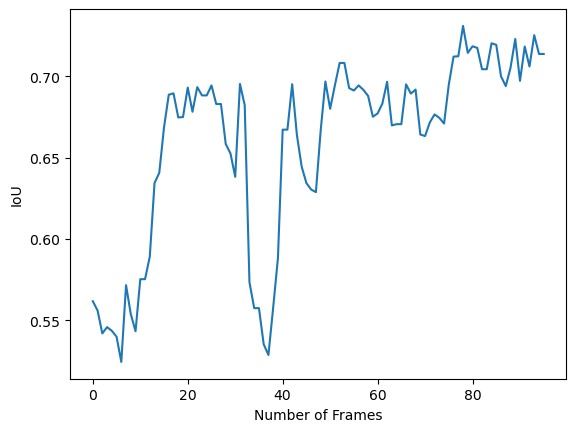

In [6]:
highIoUlist = [x for x in IoU_list if x > t_high]

print("the percentage of frames in which the IoU is larger than t_high is", len(highIoUlist) / len(IoU_list))
plt.plot(list(range(len(IoU_list))), IoU_list)
plt.xlabel('Number of Frames')
plt.ylabel('IoU')
plt.savefig('IoU.jpg')
plt.show()

In [7]:
cap = cv2.VideoCapture("KylianMbappe.mp4") # video

# capture one frame
ret,frame = cap.read()

# detect a face on the first frame
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
face_boxes = face_detector.detectMultiScale(frame)

if len(face_boxes)==0:
    print('no face detected')
    assert(False)

# initialize the tracing window around the (first) detected face
(x,y,w,h) = tuple(face_boxes[1])
track_window = (x,y,w,h)

#  region of interest for tracking
roi = frame[y:y+h, x:x+w]

# convert the roi to HSV so we can construct a histogram of Hue
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

sobel_x = cv2.Sobel(hsv_roi, cv2.CV_64F, 1,0, ksize = 5)
sobel_y = cv2.Sobel(hsv_roi, cv2.CV_64F, 0,1, ksize = 5)

magnitude, angle = cv2.cartToPolar(sobel_x,sobel_y,angleInDegrees=True)
mask = cv2.inRange(magnitude, np.array([np.max(magnitude)/10]), np.array([np.max(magnitude)]))

roi_hist = cv2.calcHist(np.array([angle], dtype=np.uint8),[0],mask,[24],[0,360])

cv2.normalize(roi_hist,roi_hist,0,360,cv2.NORM_MINMAX)

term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

IoU_list = []
high_written = False
low_written = False
previous_face = None
while True:
    # grab a frame
    ret ,frame = cap.read() 
    
    if ret == True: 
        # convert to HSV
        gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) 
        
        # histogram back projection using roi_hist 
        dst = cv2.calcBackProject([gray_image],[0],roi_hist,[0,360],1)
        
        # use meanshift to shift the tracking window
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)
        
        # display tracked window
        x,y,w,h = track_window
        img = cv2.rectangle(frame, (x,y), (x+w,y+h), (0,0,255),5)

        face_boxes = face_detector.detectMultiScale(frame)
        if len(face_boxes) > 1:
            index, maxIoU = max(enumerate(face_boxes), key=lambda x: calculate_IoU(track_window if previous_face is None else previous_face, x[1]))
            (x1, y1, w1, h1) = face_boxes[index]
        else:
            (x1, y1, w1, h1) = tuple(face_detector.detectMultiScale(frame)[0])
        truth_window = (x1,y1,w1,h1)

        img2 = cv2.rectangle(img, (x1,y1), (x1+w1,y1+h1), (0,255,0), 5)

        cv2.imshow('simple variation demo', img2)

        IoU = calculate_IoU(track_window, truth_window)

        IoU_list.append(IoU)

        if IoU > t_high and high_written == False:
            cv2.imwrite("highIoU2.jpg", img2)
            high_written = True
        if 0.3 < IoU < t_low and low_written == False:
            cv2.imwrite("lowIoU2.jpg", img2)
            low_written = True

        if cv2.waitKey(30) & 0xFF == 27: # wait a bit and exit is ESC is pressed
            break

    else:
        break

cv2.destroyAllWindows()
cap.release()

the percentage of frames in which the IoU is larger than t_high is 0.6666666666666666


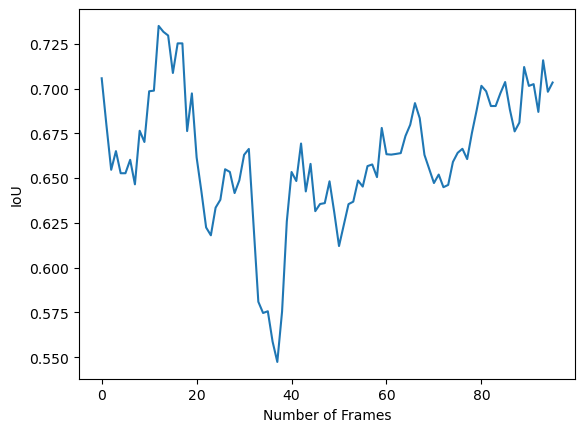

In [8]:
highIoUlist = [x for x in IoU_list if x > t_high]

print("the percentage of frames in which the IoU is larger than t_high is", len(highIoUlist) / len(IoU_list))
plt.plot(list(range(len(IoU_list))), IoU_list)
plt.xlabel('Number of Frames')
plt.ylabel('IoU')
plt.savefig('q2IoU.jpg')
plt.show()